In [135]:
import numpy as np
from utils import Classes

In [136]:
lidar = np.load("data/lidar.npy")

groundtruth = np.load("groundtruth/groundtruth.npy").reshape(-1)
hsi_raw = np.load("data/hyperspectral.npy")
hsi = hsi_raw.reshape(-1, hsi_raw.shape[-1])
idx = groundtruth.nonzero()[0]

X = hsi[idx]
y = groundtruth[idx]

X.shape, y.shape

((2832, 144), (2832,))

In [137]:
hsi_test = np.load("data/hyperspectral.npy")
hsi_test.shape

(349, 1905, 144)

In [138]:
classes = [
    Classes.GRASS_HEALTHY,
    Classes.GRASS_STRESSED,
    Classes.GRASS_SYNTHETIC,
    Classes.TREE,
    Classes.SOIL,
    Classes.WATER,
    Classes.RESIDENTIAL,
    Classes.COMMERCIAL,
    Classes.ROAD,
    Classes.HIGHWAY,
    Classes.RAILWAY,
    Classes.PARKING_LOT1,
    Classes.PARKING_LOT2,
    Classes.TENNIS_COURT,
    Classes.RUNNING_TRACK,
]

### Predict and colormap

In [139]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

In [140]:
from sklearn.metrics import confusion_matrix

def predict_and_display(model):
    def display(img, cmap):
        plt.figure(figsize=(15, 15))
        plt.imshow(img, cmap=cmap)
    def display_confusion_matrix(Y_test, y_pred):
        cm = confusion_matrix(Y_test, y_pred)
        print(cm)
    cmap = ListedColormap(
        np.array(
            [
                # [[0.0, 0.0, 0.0]],
                [[0.0, 0.80392157, 0.0]],
                [[0.49803922, 1.0, 0.0]],
                [[0.18039216, 0.80392157, 0.34117647]],
                [[0.0, 0.54509804, 0.0]],
                [[0.62745098, 0.32156863, 0.17647059]],
                [[0.0, 1.0, 1.0]],
                [[1.0, 1.0, 1.0]],
                [[0.84705882, 0.74901961, 0.84705882]],
                [[1.0, 0.0, 0.0]],
                [[0.54509804, 0.0, 0.0]],
                [[0.39215686, 0.39215686, 0.39215686]],
                [[1.0, 1.0, 0.0]],
                [[0.93333333, 0.60392157, 0.0]],
                [[0.33333333, 0.10196078, 0.54509804]],
                [[1.0, 0.49803922, 0.31372549]],
            ]
        )
    )
    hsi_reshaped = hsi.reshape(-1, hsi.shape[-1])
    lidar_reshaped = lidar.reshape(-1)
    hsi_reshaped.shape, lidar_reshaped.shape
    y_pred = model.predict(hsi_reshaped)
    img_pred = y_pred.reshape(lidar.shape)
    # display_confusion_matrix(Y_test, y_pred)
    display(img_pred, cmap)

# Try different classifiers

## Support Vector Machines model

### LinearSVC


In [141]:
from classifier import Classifier
from sklearn.svm import LinearSVC

In [142]:
LinearSVC_model = Classifier(
    classes,
    LinearSVC(random_state=0, dual="auto"),
)

X_train, Y_train, X_test, Y_test = LinearSVC_model._dataset_get(X, y, test_size=0.2)

In [143]:
LinearSVC_model.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual='auto', random_state=0))])

In [144]:
LinearSVC_model.score(X_test, Y_test)

0.8606701940035273

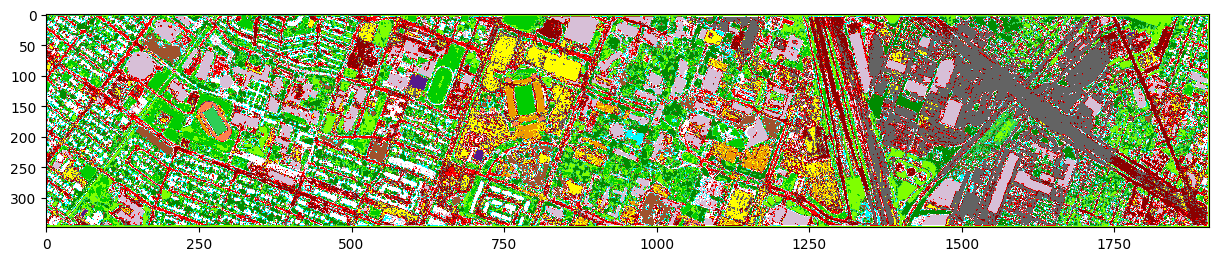

In [145]:
predict_and_display(LinearSVC_model)

In [146]:
LinearSVC_model.optimize(
    X_train,
    Y_train,
    include_unknown=False,
    model_params=dict(
        # C=(1, 100, 10000, 100000),
        # loss=('hinge', 'squared_hinge'),
        # random_state=(0, 21, 42, 84),
        # max_iter=range(100, 200, 1000, 2000),
        # penalty=("l1", "l2"),
    ),
    n_jobs=8,
    verbose=1,
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.8520971302428256

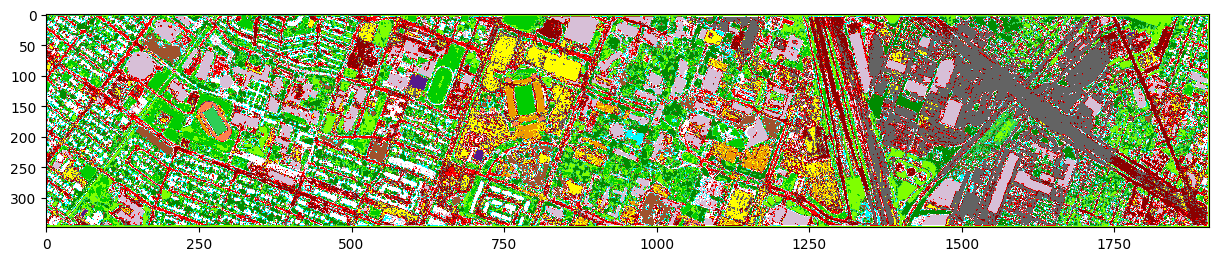

In [147]:
predict_and_display(LinearSVC_model)

## Linear model

### SGDClassifier

In [148]:
from sklearn.linear_model import SGDClassifier

In [149]:
SGDClassifier_model = Classifier(
    classes,
    SGDClassifier(random_state=0),
)

X_train, Y_train, X_test, Y_test = SGDClassifier_model._dataset_get(X, y, test_size=0.2)

In [150]:
SGDClassifier_model.fit(X_train, Y_train)
SGDClassifier_model.score(X_test, Y_test)

0.6754850088183422

In [151]:
opt_SGDClassifier_model = SGDClassifier_model.optimize(
    X_train,
    Y_train,
    include_unknown=False,
    model_params=dict(
        # random_state=(42),
        # shuffle=(False),
        # early_stopping=(True),
        ),
    n_jobs=6,
    verbose=1,
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [152]:
opt_SGDClassifier_model

0.717439293598234

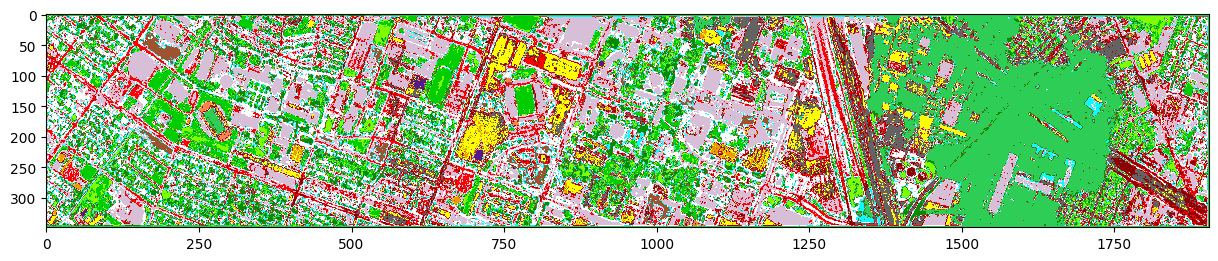

In [153]:
predict_and_display(SGDClassifier_model)

## Ensembles model

### RandomForestClassifier


In [154]:
from sklearn.ensemble import RandomForestClassifier

In [155]:
Rfc_model = Classifier(
    classes,
    RandomForestClassifier(random_state=0),
)

X_train, Y_train, X_test, Y_test = Rfc_model._dataset_get(X, y, test_size=0.2)

In [156]:
Rfc_model.fit(X_train, Y_train)
Rfc_model.score(X_test, Y_test)

0.8871252204585538

In [157]:
# opt_RFC_model = Rfc_model.optimize(
#     X_train,
#     Y_train,
#     include_unknown=False,
#     model_params=dict(
#         # n_estimators=(1, 10, 50, 100, 250, 500, 1000),
#         # max_depth=(100, 1000, 3000),

#         # min_samples_split=(2, 5, 14, 28, 50),
#         # max_leaf_nodes=(1, 10, 100, 200, 1000)
#         # class_weight=('balanced'),
#         # max_features=('sqrt', 'log2', 1, 2, 10, 14, 28),
#         # max_leaf_nodes=(None, 1, 10, 20)
#         ccp_alpha = (0.0, 0.5, 1, 5, 10)
#     ),
#     n_jobs=6,
#     verbose=1,
# )

In [158]:
# opt_RFC_model

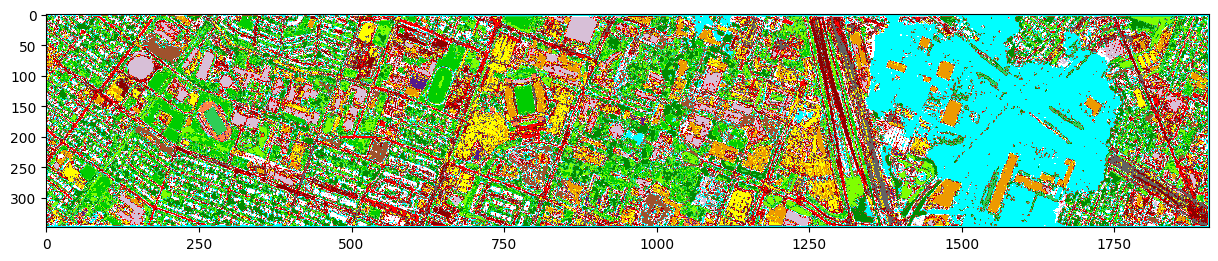

In [159]:
predict_and_display(Rfc_model)

## HistGradientBoostingClassifier

In [160]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [174]:
HGBS_model = Classifier(
    classes,
    HistGradientBoostingClassifier(random_state=0, max_iter=150),
)

X_train, Y_train, X_test, Y_test = HGBS_model._dataset_get(X, y, test_size=0.2)

In [175]:
HGBS_model.fit(X_train, Y_train)
HGBS_model.score(X_test, Y_test)

0.9506172839506173

In [163]:
opt_HGBS_model = HGBS_model.optimize(
    X_train,
    Y_train,
    include_unknown=False,
    model_params=dict(
        # max_iter=(100, 1000),
        random_state=(0, 42),
        # learning_rate=(0.1, 0.5, 0.8),
        max_iter=(100, 125, 150, 160),
        # min_samples_leaf=(10, 50, 100),
        # max_features=(1.0, 2.0, 5.0, 14.5)
        max_leaf_nodes=(20, 31, 50)
        ),
    n_jobs=8,
    verbose=1,
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [176]:
opt_HGBS_model

0.8807947019867549

In [165]:
HGBS_model._estimator.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('histgradientboostingclassifier',
   HistGradientBoostingClassifier(random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'histgradientboostingclassifier': HistGradientBoostingClassifier(random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'histgradientboostingclassifier__categorical_features': 'warn',
 'histgradientboostingclassifier__class_weight': None,
 'histgradientboostingclassifier__early_stopping': 'auto',
 'histgradientboostingclassifier__interaction_cst': None,
 'histgradientboostingclassifier__l2_regularization': 0.0,
 'histgradientboostingclassifier__learning_rate': 0.1,
 'histgradientboostingclassifier__loss': 'log_loss',
 'histgradientboostingclassifier__max_bins': 255,
 'histgradientboostingclassifier__max_depth': None,
 'histgradientboostingclassifier__max_features': 1.0,
 'histgradientboostingclassifier__max_ite

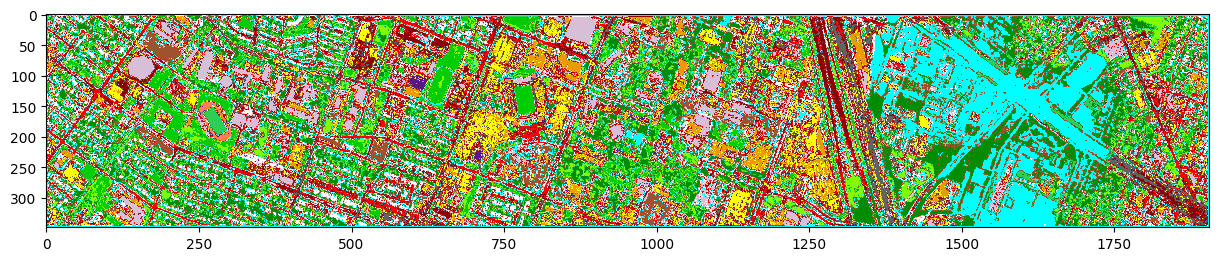

In [166]:
predict_and_display(HGBS_model)

# Fusion des données HSI & LiDAR

### Early fusion

In [167]:
lidar = np.load("data/lidar.npy")

hsi_with_lidar = np.concatenate((hsi_raw, lidar[:, :, np.newaxis]), axis=2)
hsi_with_lidar.shape


(349, 1905, 145)

In [168]:
hsi_with_lidar = hsi_with_lidar.reshape(-1, hsi_with_lidar.shape[-1])
idx = groundtruth.nonzero()[0]

X = hsi_with_lidar[idx]
y = groundtruth[idx]

X.shape, y.shape

((2832, 145), (2832,))

Classification

In [169]:
HGBS_model = Classifier(
    classes,
    HistGradientBoostingClassifier(random_state=0, max_iter=150)
)

X_train, Y_train, X_test, Y_test = HGBS_model._dataset_get(X, y, test_size=0.2)

In [170]:
HGBS_model.fit(X_train, Y_train)
HGBS_model.score(X_test, Y_test)

0.9506172839506173

In [171]:
def predict_and_display(model, image):
    def display(img, cmap):
        plt.figure(figsize=(15, 15))
        plt.imshow(img, cmap=cmap)
    def display_confusion_matrix(Y_test, y_pred):
        cm = confusion_matrix(Y_test, y_pred)
        print(cm)
    cmap = ListedColormap(
        np.array(
            [
                # [[0.0, 0.0, 0.0]],
                [[0.0, 0.80392157, 0.0]],
                [[0.49803922, 1.0, 0.0]],
                [[0.18039216, 0.80392157, 0.34117647]],
                [[0.0, 0.54509804, 0.0]],
                [[0.62745098, 0.32156863, 0.17647059]],
                [[0.0, 1.0, 1.0]],
                [[1.0, 1.0, 1.0]],
                [[0.84705882, 0.74901961, 0.84705882]],
                [[1.0, 0.0, 0.0]],
                [[0.54509804, 0.0, 0.0]],
                [[0.39215686, 0.39215686, 0.39215686]],
                [[1.0, 1.0, 0.0]],
                [[0.93333333, 0.60392157, 0.0]],
                [[0.33333333, 0.10196078, 0.54509804]],
                [[1.0, 0.49803922, 0.31372549]],
            ]
        )
    )
    hsi_reshaped = image.reshape(-1, image.shape[-1])
    y_pred = model.predict(hsi_reshaped)
    img_pred = y_pred.reshape((349, 1905))
    # display_confusion_matrix(Y_test, y_pred)
    display(img_pred, cmap)

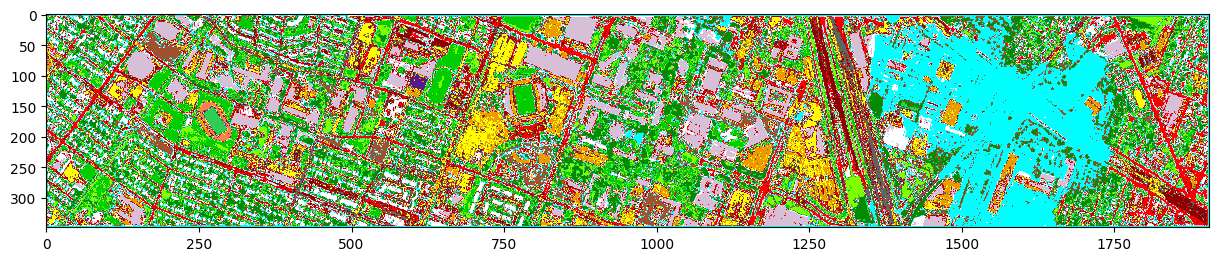

In [172]:
predict_and_display(HGBS_model, hsi_with_lidar)